In [190]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Load sample train data set

In [191]:
from create_Tatoeba_train_test import get_language_mappings, get_sentence_word_char_len

In [192]:
language_mappings = get_language_mappings("language_mappings.csv")
iso_639_2_English = language_mappings[["ISO 639-2", "English Name"]].set_index(keys="ISO 639-2")["English Name"].to_dict()
# iso_639_2_English

In [193]:
THIS_FILE = "Tatoeba_stratify_train_2021-8-4_1049.csv"
sample = pd.read_csv(f"output/{THIS_FILE}")
sample["Language_English_Name"] = sample["Language"].map(iso_639_2_English)
sample["Sentence_len"] = sample.apply(lambda row: get_sentence_word_char_len(row), axis=1)

In [194]:
bin_labels = ["1","2","3","4","5","6","7","8","9","10","11 to 16", "17 to 27", "28 to 48", "49 to 99"]

sample["Sentence_len_bin"] = pd.cut(
    x=sample["Sentence_len"],
    bins=[0,1,2,3,4,5,6,7,8,9,10,16,27,48,99],
    labels=bin_labels
)
# sample.sample(10)

In [195]:
sample.groupby(["Language"]).count()["Sentence"]

Language
cmn    4317
dan    4317
deu    4317
eng    4317
fra    4317
ita    4317
jpn    4316
kor    4316
nld    4317
nob    4316
por    4317
spa    4317
Name: Sentence, dtype: int64

> There are 12 languages in the sample & ~4,317 sentences per language for a total of 51,801 sentences.

In [196]:
sample.groupby(["Sentence_len_bin"]).count()["Sentence"]

Sentence_len_bin
1              58
2             570
3            1236
4            2161
5            3130
6            3851
7            4804
8            5798
9            6486
10           5847
11 to 16    13303
17 to 27     3749
28 to 48      645
49 to 99      163
Name: Sentence, dtype: int64

> Due to how we performed the stratified sampling each language has the same number of sentences per sentence length bin. For instance, each language should have 58 sentences of one word/character.

# langid

#### Setup for langid

In [197]:
from langid.langid import LanguageIdentifier, model

In [198]:
iso_639_2_iso_639_1 = language_mappings[["ISO 639-2", "ISO 639-1"]].set_index(keys="ISO 639-2")["ISO 639-1"].to_dict()
# iso_639_2_iso_639_1

In [199]:
# find all languages to include in langid predictions
set_languages = [iso_639_2_iso_639_1[i] for i in sample["Language"].unique().tolist()]

# unlimited langid preditions
lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

# limiting langid predictions to expected languages (sorry Galician & Afrikaans)
lang_identifier_limited = LanguageIdentifier.from_modelstring(model, norm_probs=True)
lang_identifier_limited.set_languages(set_languages)

#### Generate langid predictions

In [200]:
%%time
# 2min, 45s, with no limits on languages

sample["langid"] = sample.apply(lambda row: list(lang_identifier.classify(row["Sentence"])), axis=1)

sample["langid_language"], sample["langid_score"] = sample["langid"].str
sample.drop(columns=["langid"], inplace=True)

Wall time: 2min 54s


In [201]:
%%time
# 12s, with limited languages

sample["langid_limited"] = sample.apply(lambda row: list(lang_identifier_limited.classify(row["Sentence"])), axis=1)

sample["langid_limited_language"], sample["langid_limited_score"] = sample["langid_limited"].str
sample.drop(columns=["langid_limited"], inplace=True)

Wall time: 12.3 s


In [202]:
# map Language to English Name & langid_language to English Name
ISO_639_2 = language_mappings.set_index("ISO 639-2")
ISO_639_2 = ISO_639_2["English Name"].to_dict()
sample["Language_English_Name"] = sample["Language"].map(ISO_639_2)

ISO_639_1 = language_mappings.set_index("ISO 639-1")
ISO_639_1 = ISO_639_1["English Name"].to_dict()
sample["langid_language_English_Name"] = sample["langid_language"].map(ISO_639_1)
sample["langid_limited_language_English_Name"] = sample["langid_limited_language"].map(ISO_639_1)

In [203]:
round(sample["langid_language_English_Name"].value_counts(normalize=True, dropna=False) * 100,2)[:10]

Norwegian    10.17
Japanese      8.79
English       8.53
German        8.35
Korean        8.33
French        8.28
Italian       8.15
Dutch         8.14
Spanish       7.90
Chinese       7.88
Name: langid_language_English_Name, dtype: float64

In [204]:
round(sample["langid_limited_language_English_Name"].value_counts(normalize=True, dropna=False) * 100,2)[:10]

Japanese      8.79
English       8.64
Norwegian     8.50
French        8.46
German        8.44
Spanish       8.40
Korean        8.33
Italian       8.28
Dutch         8.26
Portuguese    8.12
Name: langid_limited_language_English_Name, dtype: float64

# langdetect

In [205]:
from langdetect import DetectorFactory
DetectorFactory.seed = 7

In [206]:
from langdetect import detect_langs

In [207]:
def get_langdetect_prediction(this_string: str):
    """
    Run langdetect on a sentence and get the results.
    
    Args:
    this_string - str; the sentence to run through langdetect.
    
    Returns:
    result - langdetect.language.Language; the langdetect output.
    """
    assert isinstance(this_string, str), "this_string is not of type str."
    
    result = None
    if len(this_string)>0:
        try:
            result = detect_langs(this_string)[0]
        except:
            result = "Error"
            print(f"Error processing sentence: {this_string}")
    return result

In [208]:
%%time
# 3min 34s

sample["langdetect"] = sample.apply(lambda row: get_langdetect_prediction(row["Sentence"]), axis=1)

Error processing sentence: 咦！？
Wall time: 3min 33s


In [209]:
def get_langdetect_lang(this_result):
    """
    Get the language-component from the langdetect results.
    
    Args:
    this_result - langdetect.language.Language; the langdetect output.
    
    Returns:
    result - str; 2-character identifier for the predicted language.
    """
    result = "!!"
    if this_result:
        try:
            result = this_result.lang
            result = result.split("-")[0] # mainly for zh-cn
        except:
            pass
    return result

def get_langdetect_prob(this_result):
    """
    Get the probability-component from the langdetect results.
    
    Args:
    this_result - langdetect.language.Language; the langdetect output.
    
    Returns:
    result - float; the probability for the predicted language.
    """
    result = 0.0
    if this_result:
        try:
            result = this_result.prob
        except:
            pass
    return result

In [210]:
sample["langdetect_language"] = sample.apply(lambda row: get_langdetect_lang(row["langdetect"]), axis=1)
sample["langdetect_score"] = sample.apply(lambda row: get_langdetect_prob(row["langdetect"]), axis=1)
# sample.drop(columns=["langdetect"], inplace=True)

In [211]:
sample["langdetect_language_English_Name"] = sample["langdetect_language"].map(ISO_639_1)

In [212]:
round(sample["langdetect_language"].value_counts(normalize=True, dropna=False) * 100,2)[:10]

ko    10.66
no     8.93
pt     8.36
fr     8.35
ja     8.26
de     8.22
en     8.16
it     8.15
es     7.87
nl     7.51
Name: langdetect_language, dtype: float64

# textblob
> Currently, requests from IP are blocked by Google

In [213]:
# from textblob import TextBlob

In [214]:
# sample["textblob"] = sample.apply(lambda x: TextBlob(str(sample["Sentence"])).detect_language(), axis=1) # HTTP Error 429: Too Many Requests

# googletrans
#### Unofficial & unsupported access to Google Translate API - support could be terminated at any time
#### Only used to evaluate results & approximate differences in results
> Currently, requests from IP are blocked by Google ?

In [215]:
# from googletrans import Translator

In [216]:
# translator = Translator()

# translator.detect("this is an English sentence.")

In [217]:
# def get_googletrans_prediction(this_string: str):
#     """
#     Run googletrans on a sentence and get the results.
    
#     Args:
#     this_string - str; the sentence to run through langdetect.
    
#     Returns:
#     result - ???; the googletrans output.
#     """
#     assert isinstance(this_string, str), "this_string is not of type str."
    
#     result = None
#     if len(this_string)>0:
#         try:
#             result = translator.detect(this_string)
#         except Exception as e:
#             result = "Error"
#             print(repr(e))
# #             print(f"Error processing sentence: {this_string}")
#     return result

In [218]:
# short_sample = sample.sample(10)

In [219]:
# short_sample["googletrans"] = short_sample.apply(lambda x: get_googletrans_prediction(x["Sentence"]), axis=1)

# Evaluate overall results

In [220]:
from sklearn.metrics import f1_score

## F1 scores

In [221]:
labels = sample["Language_English_Name"].unique().tolist()
# labels

#### langid

In [222]:
langid_f1 = round(f1_score(
    sample["Language_English_Name"],
    sample["langid_language_English_Name"],
    labels=labels,
    average="weighted"
),2)

print(f"langid F1: {langid_f1}")

langid F1: 0.94


In [223]:
langid_limited_f1 = round(f1_score(
    sample["Language_English_Name"],
    sample["langid_limited_language_English_Name"],
    labels=labels,
    average="weighted"
),2)

print(f"langid limited F1: {langid_limited_f1}")

langid limited F1: 0.95


#### langdetect

In [224]:
langdetect_f1 = round(f1_score(
    sample["Language_English_Name"],
    sample["langdetect_language_English_Name"],
    labels=labels,
    average="weighted"
),2)

print(f"langdetect F1: {langdetect_f1}")

langdetect F1: 0.93


> Overall, langid performs slightly better than langdetect, .94 & .93 respectively. Even more so when langid predictions are limited to expected languages (.95). Also, langid runs much faster when limited.

## Full, simple confusion matrices

#### langid confusion matrix

In [225]:
pd.crosstab(sample["Language_English_Name"], sample["langid_language_English_Name"])

langid_language_English_Name,Afrikaans,Albanian,Aragonese,Basque,Bosnian,Breton,Catalan,Chinese,Croatian,Czech,...,Slovenian,Spanish,Swahili,Swedish,Tagalog,Turkish,Vietnamese,Volapük,Walloon,Welsh
Language_English_Name,,,,,,,,,,,,,,,,,,,,,
Chinese,0,0,0,0,0,0,0,4063,0,0,...,0,0,0,0,0,0,0,0,0,0
Danish,0,0,0,0,1,0,0,0,3,0,...,0,3,0,18,1,0,0,0,0,3
Dutch,28,3,0,1,3,1,0,1,2,0,...,9,2,0,1,0,0,0,0,0,0
English,0,0,0,2,0,0,0,0,0,0,...,0,5,0,2,0,0,0,0,0,0
French,1,0,0,2,0,12,13,0,1,0,...,0,6,0,0,0,1,0,0,2,1
German,4,0,1,2,0,1,0,0,0,0,...,0,2,0,12,0,0,0,0,0,1
Italian,0,0,0,4,0,2,8,0,1,1,...,2,33,0,2,0,0,0,0,1,0
Japanese,0,0,0,0,0,0,0,15,0,0,...,0,0,0,0,0,0,0,0,0,0
Korean,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### langdetect confusion matrix

In [226]:
pd.crosstab(sample["Language_English_Name"], sample["langdetect_language_English_Name"])

langdetect_language_English_Name,Afrikaans,Albanian,Catalan,Chinese,Croatian,Czech,Danish,Dutch,English,Error,...,Slovak,Slovenian,Somali,Spanish,Swahili,Swedish,Tagalog,Turkish,Vietnamese,Welsh
Language_English_Name,,,,,,,,,,,,,,,,,,,,,
Chinese,3,0,0,3106,0,0,0,0,4,1,...,4,0,0,1,2,1,1,1,6,0
Danish,17,0,0,0,6,0,3394,10,7,0,...,1,3,1,1,0,47,2,1,0,5
Dutch,391,1,0,0,10,0,6,3832,10,0,...,0,6,4,1,1,4,0,1,0,0
English,28,1,2,0,1,0,14,20,4142,0,...,3,4,4,3,0,2,10,1,1,11
French,4,0,19,0,3,1,1,4,7,0,...,2,2,0,6,0,0,1,1,1,0
German,21,0,1,0,0,0,5,15,23,0,...,1,0,0,2,0,9,3,2,0,0
Italian,0,0,18,0,1,0,4,1,16,0,...,2,4,0,22,1,0,6,0,1,1
Japanese,0,0,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Korean,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Limited, colorful confusion matrices

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [228]:
"""
Below is a modified function from user Calvin Duy Canh Tran on Stack Overflow to plot a confusion matrix with any number of labels.
You can check out the original post on SO here: https://stackoverflow.com/a/50386871/1576558.
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    np.fill_diagonal(cm, 0) # fill the diagonal with zeroes to emphasize errors not correct predictions
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [229]:
from sklearn.metrics import confusion_matrix

#### langid confusion matrix

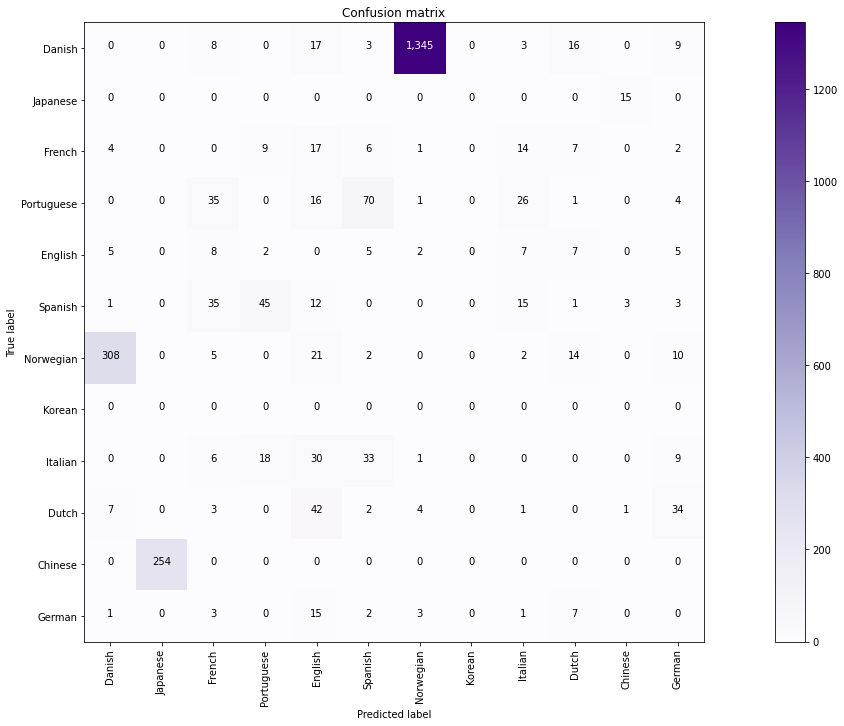

In [230]:
cm = confusion_matrix(sample["Language_English_Name"], sample["langid_language_English_Name"], labels)
plot_confusion_matrix(cm=cm, target_names=labels, normalize=False)

> langid struggled the most with Danish (1,345 errors), Norwegian (308), & Chinese (254).

#### langid limited confusion matrix

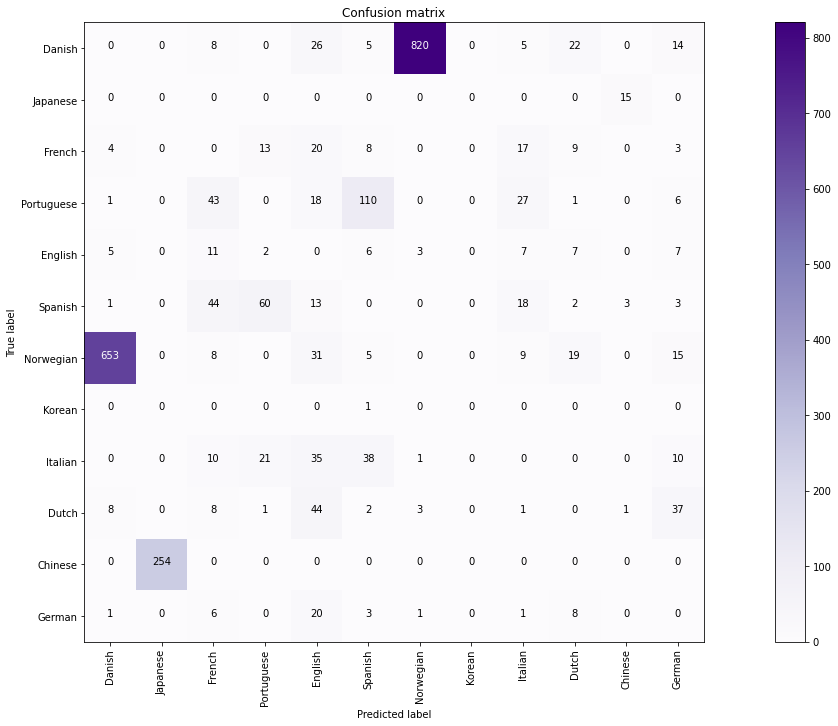

In [231]:
cm = confusion_matrix(sample["Language_English_Name"], sample["langid_limited_language_English_Name"], labels)
plot_confusion_matrix(cm=cm, target_names=labels, normalize=False)

> There are some unexpected differences between the limited langid predictions & the unlimited ones. Namely, the performance on Norwegian is significantly worse (2x), Portuguese suddenly becomes more problematic, & it performs exactly the same (errors on the same sentences?) on Chinese mistaking 254 sentences for Japanese. Regardless, the limited version of langid also struggled with Danish (820 errors), Norwegian (653), & Chinese (254).

#### langdetect confusion matrix

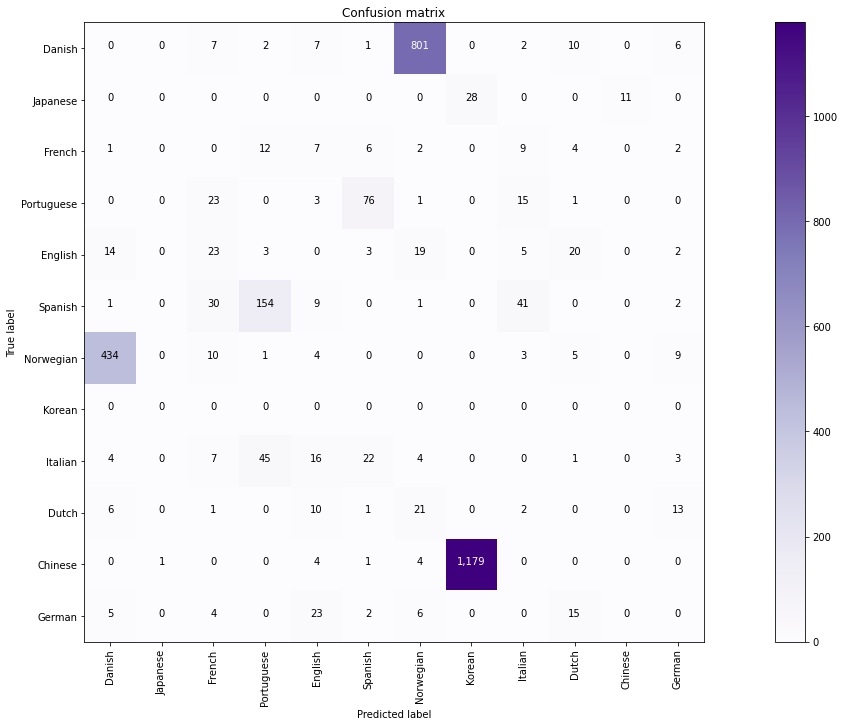

In [232]:
cm = confusion_matrix(sample["Language_English_Name"], sample["langdetect_language_English_Name"], labels)
plot_confusion_matrix(cm=cm, target_names=labels, normalize=False)

> langdetect struggled with Chinese (1,179 errors), Danish (801), & Norwegian (434).

# Takeaways
On a high-level langid & langdetect performed similarly in terms of overall F1, .94 & .93 respectively for the unlimited versions. They even struggled with the same languages (Danish, Chinese, & Norwegian) albeit to different extents.

We can perform these evaluations on any number of samples using get_predictions.ipynb to see how they generalize but the results are not drastically different than for 1 sample.

Based on these results I would opt for using a limited version of langid because 1) it's an order of magnitude faster than langdetect, 2) it inherently provides deterministic results, 3) its F1 score is at least as good as, if not better, than langdetect's (being charitable here by generalizing beyond this sample), & 4) it appears to be less problematic with Chinese than langdetect which is much more common than Danish or Norwegian.

We'll extend this evaluation by looking at aggregated results from 100 samples by languages & as a function of sentence length in plot_results.ipynb.

## Capture results as a function of sentence length [optional]

In [233]:
results = []
for this_bin in bin_labels:
    bin_results = sample[sample["Sentence_len_bin"]==this_bin]
    for lang in bin_results["Language_English_Name"].unique().tolist():
        these_results = bin_results[(bin_results["Language_English_Name"]==lang)]
        for prediction in ["langid", "langdetect"]:
            these_labels = these_results["Language_English_Name"].unique().tolist()
            this_f1 = f1_score(these_results["Language_English_Name"], these_results[f"{prediction}_language_English_Name"], labels=these_labels, average="weighted")
            result = (this_bin, lang, prediction, round(this_f1,2))
            results.append(result)

#### Export results above for plotting

In [234]:
from datetime import datetime

In [235]:
now = datetime.now()
datetime_stamp = f"{now.year}-{now.month}-{now.day}_{now.hour}{now.minute}"

results = pd.DataFrame(data=results, columns=["Bin", "Language", "Source", "F1"])
RESULTS_FILE = f"output/results_df_{datetime_stamp}.csv"
results.to_csv(RESULTS_FILE, index=False)

print(f"Results file saved: {RESULTS_FILE}")

Results file saved: output/results_df_2021-8-19_1928.csv


# End